In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
from numpy.fft import fft, fftfreq, fftshift
# from cfo_estimation.blue import cfo_est_blue as blue_estimator
from cfo_estimation.blue import unfinished_cfo_est_2 as blue_estimator
# from cfo_estimation.blue import cfo_est_aom_r as aom_r_estimator 
# from cfo_estimation.blue import cfo_est_aom_nr as aom_nr_estimator 
# from cfo_estimation.blue import cfo_est_moa_r as moa_r_estimator 
# from cfo_estimation.blue import cfo_est_moa_nr as moa_nr_estimator 
# from cfo_estimation.blue import cfo_est_conventional as conventional_estimator 
# from cfo_estimation.blue import cfo_est_mle as mle_estimator 


In [3]:
# frequency_offset_test_cases = np.arange(-200000, 200000, 1000)  # Cycles per second
frequency_offset_test_cases = np.arange(-200000, 200000, 10000)  # Cycles per second
sampling_frequency = 1500000    # Samples per second
acceptable_error = 100  # Cycles per second offset

In [4]:
# Test Signal Parameters
# signal_length_s = 4 # s
signal_length_s = 8 # s
sampling_freq_hz = 1000000 # Hz
center_freq_hz = 172000000 # Hz
offset_freq_hz = 5000 # Hz offset from center
ping_duration_s = 0.05 # s
ping_period_s = 1 # s
ping_power_db = -30 # dB
noise_power_db = -60 # dB

In [5]:
# Hyper parameters (From rct-dsp3/DSP-PING-main/dsp/results, in which the CFO estimation results seem accurate for the only tested CFO value 5000 Hz).

# Sampling Frequency (Hz): 1000000
# sampling_freq_hz = 1000000 #Hz

# Carrier (Central) Frequency (Hz): 172000000
# center_freq_hz = 172000000 #Hz 

# Pilot Block Length (P): 64
p = 64

# Pilot Block Length (M): 64
m = 64

# Data Block Length (N): 1024
n = 1024

# Number of Frames (B): 8
b = 8

# Number of Frames (B', for Reuse): 9
b_dash = 9

# Transmission Block Length (Q): 6464
q = 6464

# Decimation Rate (ψ): 4
psi = 4

# Backoff Rate (ignored) (D): 4
d = 4

In [6]:
# m = ping_duration_s * sampling_freq_hz
# n = (ping_period_s - ping_duration_s) * sampling_freq_hz
# b = n
# p = m
# q = m+n
# b_dash = b+1

In [7]:
def generate_test_signal(
        signal_length_s: float = 4.0,
        sampling_freq_hz: float = 1e6,
        offset_freq_hz: float = 5e3,
        ping_duration_s: float = 50e-3,
        ping_period_s: float = 1.0,
        ping_power_db: float = -30.0,
        noise_power_db: float = -60.0) -> np.ndarray:
    # Computed signal parameters
    ping_amplitude = 10 ** (ping_power_db / 20) # FS
    ping_time_index = np.arange(0, ping_duration_s, 1/sampling_freq_hz)
    offset_freq_rad_p_sample = offset_freq_hz * 2 * np.pi
    ping_phase_seq_rad = offset_freq_rad_p_sample * ping_time_index
    ping_signal = np.cos(ping_phase_seq_rad) + 1j * np.sin(ping_phase_seq_rad)

    noise_snr = 10.0 ** (noise_power_db / 10.0)
    noise_length_s = ping_period_s - ping_duration_s
    noise_length_samples = int(noise_length_s * sampling_freq_hz)
    noise_stddev_amplitude = np.sqrt(noise_snr*2.0)/2.0
    ping_wait_signal = np.random.normal(loc=0,
                                        scale=noise_stddev_amplitude,
                                        size=(noise_length_samples, 2)).view(np.complex128) # Generate noise with calculated power
    ping_wait_signal = np.squeeze(ping_wait_signal)
    noise_component = np.random.normal(loc=0,
                                    scale=noise_stddev_amplitude,
                                    size=(len(ping_signal), 2)).view(np.complex128)
    noise_component = np.squeeze(noise_component)
    ping_signal_noise = ping_amplitude * ping_signal + noise_component # Generate noise with calculated power

    signal = np.array([0.00001])
    golden_ping_idx = []
    for _ in range(int(signal_length_s / ping_period_s)):
        signal = np.append(signal, ping_signal_noise)
        golden_ping_idx.append(len(signal))
        signal = np.append(signal, ping_wait_signal)
    signal = np.append(signal, ping_signal_noise)
    return signal

In [8]:
# signal = generate_test_signal(signal_length_s=signal_length_s,
#                               sampling_freq_hz=sampling_freq_hz,
#                               offset_freq_hz=offset_freq_hz,
#                               ping_duration_s=ping_duration_s,
#                               ping_period_s=ping_period_s,
#                               ping_power_db=ping_power_db,
#                               noise_power_db=noise_power_db)
# plt.specgram(signal,
#              NFFT=1024,
#              Fs=sampling_freq_hz)
# plt.grid()
# plt.xlabel('Time (s)')
# plt.ylabel('Offset (Hz)')

In [9]:
# errors_blue = [[],[],[],[]]
errors_blue = []
errors_aom_r=[]
errors_aom_nr=[]
errors_moa_r=[]
errors_moa_nr=[]
errors_conventional=[]
errors_mle=[]

m_arr=[16,32,64,128]
# blue est
# for i in range(len(m_arr)):
for i in range(len(frequency_offset_test_cases)):
    test_signal = generate_test_signal(signal_length_s=signal_length_s,
                                  sampling_freq_hz=sampling_freq_hz,
                                  offset_freq_hz=frequency_offset_test_cases[i],
                                  ping_duration_s=ping_duration_s,
                                  ping_period_s=ping_period_s,
                                  ping_power_db=ping_power_db,
                                  noise_power_db=noise_power_db) 
    blue_cfo_est = blue_estimator(test_signal, f_s=sampling_freq_hz, R=sampling_freq_hz * ping_period_s)
    error = abs(blue_cfo_est - frequency_offset_test_cases[i])
    errors_blue.append(error)
    print(f'estimate = {blue_cfo_est}')
    print(f'error = {error}\n')
# other estimators
# for i in range(len(frequency_offset_test_cases)):
#         aom_r_est = aom_r_estimator(test_signals[i],b_dash=b_dash, b=b, m=m, q=q, psi=psi, p=p)
#         aom_nr_est = aom_nr_estimator(test_signals[i],)
#         moa_r_est = moa_r_estimator(test_signals[i],)
#         moa_nr_est = moa_nr_estimator(test_signals[i],)
#         conventional_est = conventional_estimator(test_signals[i],)
#         mle_est = mle_estimator(test_signals[i],)
        
#         errors_aom_r.append(abs(aom_r_est - frequency_offset_test_cases[i]))
#         errors_aom_nr.append(abs(aom_nr_est - frequency_offset_test_cases[i]))
#         errors_moa_r.append(abs(moa_r_est - frequency_offset_test_cases[i]))
#         errors_moa_nr.append(abs(moa_nr_est - frequency_offset_test_cases[i]))
#         errors_conventional.append(abs(conventional_est - frequency_offset_test_cases[i]))
#         errors_mle.append(abs(mle_est - frequency_offset_test_cases[i]))

N=8050010,U=8
estimate = -200000.99134198832
error = 0.9913419883232564

N=8050010,U=8
estimate = -189999.30357140384
error = 0.6964285961585119

N=8050010,U=8
estimate = -180002.26280837954
error = 2.262808379542548

N=8050010,U=8
estimate = -169998.55738064667
error = 1.4426193533290643

N=8050010,U=8
estimate = -160002.71282070078
error = 2.712820700777229

N=8050010,U=8
estimate = -149998.60294232273
error = 1.3970576772699133

N=8050010,U=8
estimate = -139998.0505142265
error = 1.9494857735116966

N=8050010,U=8
estimate = -130001.80444500758
error = 1.8044450075831264

N=8050010,U=8
estimate = -119999.17165678654
error = 0.8283432134630857

N=8050010,U=8
estimate = -109999.44294460495
error = 0.5570553950528847

N=8050010,U=8
estimate = -99997.4734065232
error = 2.5265934767958242

N=8050010,U=8
estimate = -89998.31720330344
error = 1.6827966965647647

N=8050010,U=8
estimate = -79999.85000434417
error = 0.14999565582547802

N=8050010,U=8
estimate = -69999.78963160125
error = 0.210

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Estimator performance')

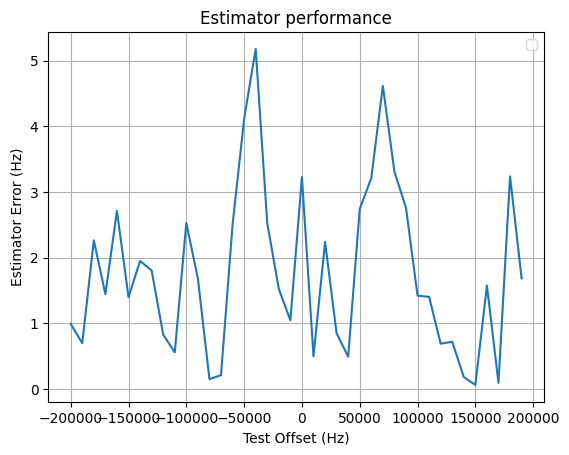

In [10]:
# for i in range(len(m_arr)):
    # plt.plot(frequency_offset_test_cases, errors_blue[0], label = f'm={m_arr[i]}')
plt.plot(frequency_offset_test_cases, errors_blue)
    
plt.xlabel('Test Offset (Hz)')
plt.ylabel('Estimator Error (Hz)')
plt.legend(loc='best')
plt.grid()
plt.title('Estimator performance')

In [ ]:
# plot for other estimator errors
# def plot_cfo_est_errors(estimator_name ,frequency_offset_test_cases, errors):
#     plt.plot(frequency_offset_test_cases, errors_blue[0])
    
#     plt.xlabel('Test Offset (Hz)')
#     plt.ylabel('Estimator Error (Hz)')
#     plt.title(estimator_name)
#     plt.grid()
#     plt.title('Estimator performance')
# plot_cfo_est_errors("aom_r", frequency_offset_test_cases, errors_aom_r)
# plot_cfo_est_errors("aom_nr", frequency_offset_test_cases, errors_aom_nr)
# plot_cfo_est_errors("moa_r", frequency_offset_test_cases, errors_moa_r)
# plot_cfo_est_errors("moa_nr", frequency_offset_test_cases, errors_moa_nr)
# plot_cfo_est_errors("conventional", frequency_offset_test_cases, errors_conventional)
# plot_cfo_est_errors("mle", frequency_offset_test_cases, errors_mle)